# Image Classifier

Contains code for the `ImageClassifer` class, which loads a neural network on the Movidius NCS, takes pictures using a pi cam, passes the (preprocessed) pics through the stick and decodes the result into a bounding box around the category of your choice.

Main workflow when importing:
1. `import image_classifier`
2. `IC = image_classifier.ImageClassifier()`
3. Repeat:
    - `img_array = IC.take_picture_and_start_inference()`
    - `output_dict, bb, inference_time_ms = IC.get_inference_result()`
    - `if bb == -1:`
        - `    img = PIL.Image.fromarray(img_array)`
    - `else:`
        - `    (x1, y1), (x2, y2) = bb  # do stuff`

---

TODO: Much of the code comes from the Movidius GitHub repo, and should be attributed properly!

---

I find development using a notebook to be quite a bit easier than developing using a regular python file. Unfortunately, you can't import a `.ipynb` as a module. So, here's the workflow:
1. Use this file to understand the code and make changes
2. When you want to commit a change, click `Kernal > Restart and Clear Output` to remove your outputs + make the file a bit smaller (shows up as fewer lines in the git commit)
3. Run the command `jupyter nbconvert --to=python image_classifier.ipynb` to generate a `.py` file which can be imported as a module. Just make sure to remove your debugging code beforehand!

In [1]:
import os, time
import numpy as np
import picamera, picamera.array
import mvnc.mvncapi as mvnc
# import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import multiprocessing
import sys

## Open the NCS device and load the graph file

In [2]:
# ****************************************************************************
# Copyright(c) 2017 Intel Corporation.
# License: MIT See LICENSE file in root directory.
# ****************************************************************************

# DIY smart security camera PoC using Raspberry Pi Camera and
# Intel® Movidius™ Neural Compute Stick (NCS)

def open_ncs_device_and_load_graph(graph_filename):
    # Look for enumerated NCS device(s); quit program if none found.
    devices = mvnc.enumerate_devices()
    if len(devices) == 0:
        print('No NCS devices found')
        exit()

    # Get a handle to the first enumerated device and open it
    device = mvnc.Device(devices[0])
    device.open()

    # Read the graph file into a buffer
    with open(graph_filename, mode='rb') as f:
        blob = f.read()

    # Load the graph buffer into the NCS
    graph = mvnc.Graph(graph_filename)
    fifo_in, fifo_out = graph.allocate_with_fifos(device, blob)

    return device, graph, fifo_in, fifo_out

## Pre-process the image (resizing, scaling, and mean subtraction)

In [3]:
def pre_process_image(img, dim, mean, scale):
#     img = PIL.Image.fromarray(frame.array)#.resize(dim)
#     img = np.array(img, dtype=np.float32)
#     if img.shape != (dim[0], dim[1], 3):
#         img = img[:dim[0], :dim[1], :]
#         print('resizing in preprocess function')

    # Mean subtraction & scaling [A common technique used to center the data]
    img = (img - np.float32(mean)) * np.float32(scale)

    return img

## Get the inference result

In [4]:
def get_inference_result(graph, shape, fifo_in, fifo_out, confidance_threshold=0.6):
    # Get the results from NCS
    output, userobj = fifo_out.read_elem()

    # Get execution time
    inference_time = np.sum(graph.get_option(mvnc.GraphOption.RO_TIME_TAKEN))

    # Deserialize the output into a python dictionary
    output_dict = deserialize_ssd(output, shape, confidance_threshold)

    return output_dict, inference_time

In [5]:
# ****************************************************************************
# Copyright(c) 2017 Intel Corporation. 
# License: MIT See LICENSE file in root directory.
# ****************************************************************************

# Utilities to help deserialize the output list from
# Intel® Movidius™ Neural Compute Stick (NCS)
def deserialize_ssd(output, shape, confidance_threshold):
    """---- Deserialize the output from an SSD based network ----
    
    @param output The NCS returns a list/array in this structure:
        First float16: Number of detections
        Next 6 values: Unused
        Next consecutive batch of 7 values: Detection values
          0: Image ID (always 0)
          1: Class ID (index into labels.txt)
          2: Detection score
          3: Box left coordinate (x1) - scaled value between 0 & 1
          4: Box top coordinate (y1) - scaled value between 0 & 1
          5: Box right coordinate (x2) - scaled value between 0 & 1
          6: Box bottom coordinate (y2) - scaled value between 0 & 1

    @return output_dict A Python dictionary with the following keys:
        output_dict['num_detections'] = Total number of valid detections
        output_dict['detection_classes_<X>'] = Class ID of the detected object
        output_dict['detection_scores_<X>'] = Percentage of the confidance
        output_dict['detection_boxes_<X>'] = A list of 2 tuples [(x1, y1) (x2, y2)]
        Where <X> is a zero-index count of num_detections
    """

    output_dict = {}                # Dictionary where the deserialized output will be stored
    height, width = shape  # Extract the original image's shape
    channel = 3
    output_dict['num_detections'] = int(output[0])  # Total number of detections
    num_valid_detections = 0

    for detection in range(output_dict['num_detections']):
        base_index = 7 + (7 * detection)  # Skip the first 7 values

        if (output[base_index + 2] > confidance_threshold):
            output_dict['detection_classes_' + str(num_valid_detections)] = int(output[base_index + 1])
            output_dict['detection_scores_' + str(num_valid_detections)] = int(output[base_index + 2] * 100)

            x = [int(output[base_index + 3] * width), int(output[base_index + 5] * width)]
            y = [int(output[base_index + 4] * height), int(output[base_index + 6] * height)]

            output_dict['detection_boxes_' + str(num_valid_detections)] = list(zip(y, x))

            num_valid_detections += 1

    # Update total number of detections to valid detections
    output_dict['num_detections'] = int(num_valid_detections)

    return output_dict

In [6]:
def output_dict_to_bb_and_angles(output_dict, class_of_interest, camera_resolution, camera_FOV):
    for i in range(output_dict['num_detections']):
        if (output_dict.get('detection_classes_%i' % i) == class_of_interest):
            (y1, x1) = output_dict.get('detection_boxes_' + str(i))[0]
            (y2, x2) = output_dict.get('detection_boxes_' + str(i))[1]
            bb = (x1, y1), (x2, y2)

            w, h = camera_resolution
            cam_width = camera_FOV[0]
            cam_height = camera_FOV[1]
            x1_angle = pixel_to_angle(x1, w, cam_width)
            x2_angle = pixel_to_angle(x2, w, cam_width)
            y1_angle = pixel_to_angle(y1, h, cam_height)
            y2_angle = pixel_to_angle(y2, h, cam_height)
            bb_angles = ((x1_angle, y1_angle), (x2_angle, y2_angle))

            return bb, bb_angles

## Utils

In [7]:
def pixel_to_angle(pixel, img_size, cam_angle_deg):
    """ convert a pixel value to an angle in degrees
    inputs:
        pixel:              a value from 0 to img_size
        img_size:           the total number of pixels along that axis of the image
        cam_angle_deg:      the angular width of camera in degrees
        
    output:
        angle:      0deg = when pixel is directly ahead, positive/negative = right/left of center
    """
    norm_pixel = (2*pixel/img_size) - 1  # now in range [-1, 1]
    angle = np.arctan(norm_pixel * np.tan(np.deg2rad(cam_angle_deg/2)))
    return np.rad2deg(angle)

## The ImageClassifier class

In [8]:
def take_pictures(raw_image_queue, # for multiprocessing
                  camera_resolution, colourmode,
                  nn_shape,
                  debug):
    
    ##### OPEN THE CAMERA AND START STREAMING #####
    if debug: print('CAMERA: initialising camera') 
    with picamera.PiCamera(resolution=camera_resolution, framerate=90) as camera:
        frame = picamera.array.PiRGBArray(camera, size=nn_shape)
        cont_capture = camera.capture_continuous(frame, colourmode,
                                                 resize=nn_shape,
                                                 use_video_port=True)# use GPU for resizing
        next(cont_capture)  # next frame in the continuous capture
        
        while True:
            if debug: print('CAMERA: starting loop - taking a picture')
            if debug: t = time.time()
            
            frame.seek(0)
            frame.truncate(0)
            next(cont_capture)  # next frame in the continuous capture            
            
            if debug: print('CAMERA: picture taken. Checking if queue is empty')
            
            while not raw_image_queue.empty():
                pass
            
            if debug: print('CAMERA: putting pic in queue')
            raw_image_queue.put(frame.array)

In [9]:
def preprocess_and_infer(raw_image_queue, dict_queue,  # for multiprocessing
                         device, graph, fifo_in, fifo_out,
                         nn_shape, mean, scale,
                         debug):

    ##### OPEN AND INIT THE NCS #####
#     if debug: print('opening NCS device')
#     device, graph, fifo_in, fifo_out = open_ncs_device_and_load_graph(graph_filename)


    while True:
        if debug: print('PREPROCESS: starting loop - getting image from queue')
        img = raw_image_queue.get()

        if debug: print('PREPROCESS: preprocessing image')
        preprocessed_img = pre_process_image(img, nn_shape, mean, scale)
        
        if debug: print('PREPROCESS: putting output dict onto queue')
        
        dict_queue.put(preprocessed_img)

#         if debug: print('PREPROCESS: queueing image for inference')
#         graph.queue_inference_with_fifo_elem(fifo_in, fifo_out, preprocessed_img, None)

#         if debug: print('PREPROCESS: getting inference result')
#         output_dict, _ = get_inference_result(graph, nn_shape, fifo_in, fifo_out)

#         if debug: print('PREPROCESS: putting output dict onto queue')
#         dict_queue.put(output_dict)

In [10]:
class ImageClassifier():
    def __init__(self,
                 graph_filename='graph',
                 label_filename='categories.txt',  # must correspond to the specific network
                 class_of_interest='person',
                 colourmode='rgb',
                 camera_resolution=(1280, 720),# (width, height)
                 nn_shape=(300, 300),          # (width, height)
                 camera_FOV=(62.2, 48.8),      # (width, height)):
                 mean=(127.5, 127.5, 127.5),   # depends on the colourmode
                 scale=0.00789,                # = 1/127
                 debug=False):
        
        if debug: print('ImageClassifier: opening NCS device')
        self.device, self.graph, self.fifo_in, self.fifo_out = \
            open_ncs_device_and_load_graph(graph_filename)
        
        labels = [line.rstrip('\n') for line in open(label_filename) if line != 'classes\n']
        self.class_of_interest = labels.index(class_of_interest) # note conversion from string to ID (int)
        self.nn_shape = nn_shape
        self.camera_FOV = camera_FOV
        
        self.raw_image_queue = multiprocessing.Queue()
        self.dict_queue = multiprocessing.Queue()
        
        photo_process = multiprocessing.Process(target=take_pictures,
                                                args=(self.raw_image_queue,
                                                      camera_resolution, colourmode,
                                                      nn_shape,
                                                      debug))
        photo_process.start()
        
        infer_process = multiprocessing.Process(target=preprocess_and_infer,
                                                args=(self.raw_image_queue, self.dict_queue,
                                                      self.device, self.graph, self.fifo_in, self.fifo_out,
                                                      nn_shape, mean, scale,
                                                      debug))
        infer_process.start()
        
        if debug: print('ImageClassifier: started processes')
    
    def get_result(self, debug=False):
        if debug: print('ImageClassifier: getting img from queue')
        preprocessed_img = self.dict_queue.get()
        
        if debug: print('ImageClassifier: queueing for inference')
        self.graph.queue_inference_with_fifo_elem(self.fifo_in, self.fifo_out, preprocessed_img, None)

#         if debug: print('PREPROCESS: getting inference result')
        output_dict, _ = get_inference_result(self.graph, self.nn_shape, self.fifo_in, self.fifo_out)
        
        print('output_dict =', output_dict)
        bb, bb_angles = output_dict_to_bb_and_angles(output_dict,
                                                     self.class_of_interest,
                                                     self.nn_shape,
                                                     self.camera_FOV)
        return bb, bb_angles
    
    
    def __del__(self):
        self.fifo_in.destroy()
        self.fifo_out.destroy()
        self.graph.destroy()
        self.device.close()
        self.device.destroy()

In [11]:
IC = ImageClassifier(graph_filename='../Models/MobileNet_SSD_caffe/graph',
                     label_filename='../Models/MobileNet_SSD_caffe/categories.txt',
                     camera_resolution=(1280,720),
                     debug=False)

bb_arr = []
bb_angles_arr = []
t_start = time.time()
time_arr = []

while True:
    print('MAIN: getting results:')
    t = time.time()
    bb, bb_angles = IC.get_result()
    bb_arr.append(bb)
    bb_angles_arr.append(bb_angles)
    print('loop:', time.time() - t)
    time_arr.append(time.time() - t_start)

/usr/lib/python3/dist-packages/picamera/encoders.py:521: PiCameraAlphaStripping: using alpha-stripping to convert to non-alpha format; you may find the equivalent alpha format faster
  "using alpha-stripping to convert to non-alpha "
/usr/lib/python3/dist-packages/picamera/encoders.py:544: PiCameraResolutionRounded: frame size rounded up from 300x300 to 320x304
  width, height, fwidth, fheight)))


MAIN: getting results:


/usr/lib/python3/dist-packages/picamera/array.py:175: PiCameraDeprecated: This method changes the position of the stream to the truncated length; this is deprecated functionality and you should not rely on it (seek before or after truncate to ensure position is consistent)
  'This method changes the position of the stream to the '
/usr/local/lib/python3.5/dist-packages/mvnc/mvncapi.py:418: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  tensor = numpy.fromstring(tensor.raw, dtype=numpy.float32)


output_dict = {'detection_scores_1': 96, 'detection_classes_0': 9, 'detection_classes_1': 15, 'detection_boxes_0': [(85, 46), (273, 95)], 'detection_boxes_1': [(0, 106), (232, 285)], 'detection_scores_0': 81, 'num_detections': 2}
loop: 0.6510248184204102
MAIN: getting results:
output_dict = {'detection_scores_1': 96, 'detection_classes_0': 9, 'detection_classes_1': 15, 'detection_boxes_0': [(85, 46), (271, 95)], 'detection_boxes_1': [(-1, 105), (233, 286)], 'detection_scores_0': 80, 'num_detections': 2}
loop: 0.13771438598632812
MAIN: getting results:
output_dict = {'detection_scores_1': 96, 'detection_classes_0': 9, 'detection_classes_1': 15, 'detection_boxes_0': [(85, 47), (273, 96)], 'detection_boxes_1': [(-1, 105), (232, 285)], 'detection_scores_0': 67, 'num_detections': 2}
loop: 0.17123794555664062
MAIN: getting results:
output_dict = {'detection_scores_1': 90, 'detection_classes_0': 9, 'detection_classes_1': 15, 'detection_boxes_0': [(85, 47), (272, 94)], 'detection_boxes_1': [(-

output_dict = {'detection_scores_0': 100, 'detection_classes_0': 15, 'num_detections': 1, 'detection_boxes_0': [(2, 86), (242, 208)]}
loop: 0.14031434059143066
MAIN: getting results:
output_dict = {'detection_scores_0': 99, 'detection_classes_0': 15, 'num_detections': 1, 'detection_boxes_0': [(4, 102), (242, 215)]}
loop: 0.14401650428771973
MAIN: getting results:
output_dict = {'detection_scores_0': 89, 'detection_classes_0': 15, 'num_detections': 1, 'detection_boxes_0': [(1, 121), (243, 222)]}
loop: 0.13759541511535645
MAIN: getting results:
output_dict = {'num_detections': 0}


TypeError: 'NoneType' object is not iterable

Process Process-1:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-8-4ce79c25d8ec>", line 21, in take_pictures
    next(cont_capture)  # next frame in the continuous capture
  File "/usr/lib/python3/dist-packages/picamera/camera.py", line 1701, in capture_continuous
    encoder.start(output)
  File "/usr/lib/python3/dist-packages/picamera/encoders.py", line 1166, in start
    super(PiRawImageMixin, self).start(output)
  File "/usr/lib/python3/dist-packages/picamera/encoders.py", line 380, in start
    self.parent._start_capture(self.camera_port)
  File "/usr/lib/python3/dist-packages/picamera/camera.py", line 521, in _start_capture
    port.params[mmal.MMAL_PARAMETER_CAPTURE] = True
  File "/usr/lib/python3/dist-packages/picamera/mmalobj.py", line 1493, in __setitem_

In [12]:
import matplotlib.pyplot as plt

In [13]:
x_angles = [(xL+xR)/2 for ((xL, _), (xR, _)) in bb_angles_arr]
loop_times_ms = [(t-t_)*1000 for t_,t in zip(time_arr[0:-1], time_arr[1:])]

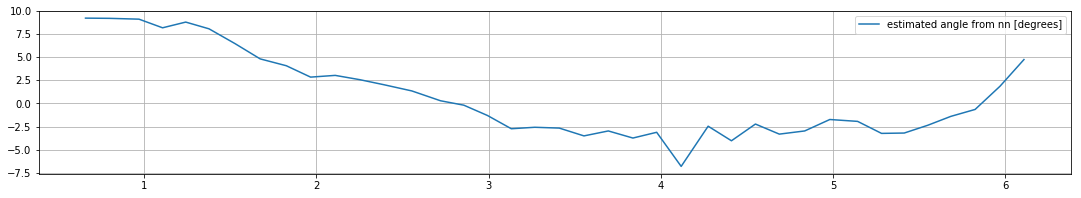

In [14]:
plt.plot(time_arr, x_angles, label='estimated angle from nn [degrees]')
plt.grid(); plt.legend(); fig = plt.gcf(); fig.set_size_inches(18.5, 3, forward=True); plt.show()

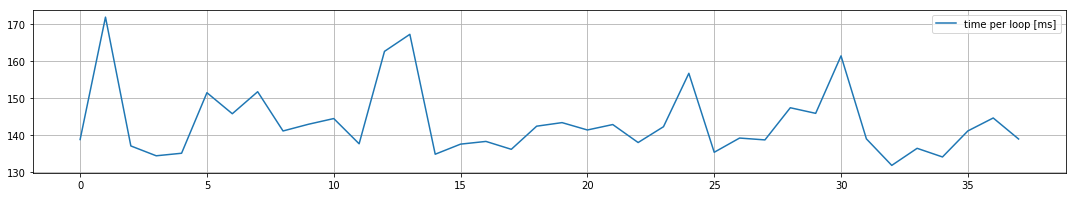

In [15]:
plt.plot(loop_times_ms, label='time per loop [ms]')
plt.legend(); plt.grid(); fig = plt.gcf(); fig.set_size_inches(18.5, 3, forward=True); plt.show()

In [16]:
IC.raw_image_queue.qsize()

0

In [17]:
IC.dict_queue.qsize()

155

In [ ]:
# im = IC.raw_image_queue.get()
# PIL.Image.fromarray(im)

In [ ]:
# f = None
# with picamera.PiCamera(resolution=(1280, 720), framerate=90) as camera:
#     frame = picamera.array.PiRGBArray(camera, size=(300,300))
#     cont_capture = camera.capture_continuous(frame, 'rgb', resize=(300,300), use_video_port=True)# use GPU for resizing
#     next(cont_capture)  # next frame in the continuous capture
#     print(frame)
#     f = frame

In [ ]:
# IC.__del__()

## Functions for displaying images

In [ ]:
def display_image(output_dict, class_of_interest, frame, labels, capture_screenshots=False):
    # Print the results (each image/frame may have multiple objects)
    for i in range(output_dict['num_detections']):
        
        if (output_dict.get('detection_classes_' + str(i)) == class_of_interest):
            
            # Extract top-left & bottom-right coordinates of detected objects
            (y1, x1) = output_dict.get('detection_boxes_' + str(i))[0]
            (y2, x2) = output_dict.get('detection_boxes_' + str(i))[1]

            # Prep string to overlay on the image
            display_str = (labels[output_dict.get('detection_classes_%i' % i)]
                           + ': %s%%' % output_dict.get('detection_scores_%i' % i))

            # Overlay bounding boxes, detection class and scores
            frame = draw_bounding_box( 
                        y1, x1, y2, x2,
                        frame, display_str=display_str)

    if capture_screenshots:
        img = PIL.Image.fromarray(frame)
        img.save('captures/photo_%s.jpg' % cur_time)

    # If a display is available, show image on which inference was performed
    if 'DISPLAY' in os.environ:
        img.show()

# ****************************************************************************
# Copyright(c) 2017 Intel Corporation. 
# License: MIT See LICENSE file in root directory.
# ****************************************************************************

# Utilities to help visualize the output from
# Intel® Movidius™ Neural Compute Stick (NCS)
def draw_bounding_box(y1, x1, y2, x2, 
                      img, 
                      thickness=4, 
                      color=(255, 255, 0),
                      display_str=()):
    """ draw a bounding box on an image to help visualise the nn output
    
    Inputs
        (x1, y1)  = Top left corner of the bounding box
        (x2, y2)  = Bottom right corner of the bounding box
        img       = Image/frame represented as numpy array
        thickness = Thickness of the bounding box's outline
        color     = Color of the bounding box's outline
    """
    img = PIL.Image.fromarray(img)
    draw = PIL.ImageDraw.Draw(img)

    for x in range(0, thickness):
        draw.rectangle([(x1-x, y1-x), (x2-x, y2-x)], outline=color)

    font = PIL.ImageFont.load_default()
    draw.text((x1, y1), display_str, font=font)

    return np.array(img)